In [1]:
import pandas as pd
import numpy as np
import sys
import os
import datetime as dt
sys.path.append('./Others/Data_Science/Project')

In [2]:
Temp2023 = pd.read_csv('Temp2023.csv', encoding='cp949')
sub2023 = pd.read_csv('sub2023.csv', encoding='cp949')
Temp2024 = pd.read_csv('Temp2024.csv', encoding='cp949')
sub2024 = pd.read_csv('sub2024.csv', encoding='cp949')
sub2022 = pd.read_csv('sub2022.csv', encoding='cp949')
Temp2022 = pd.read_csv('Temp2022.csv', encoding='cp949')

/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_26312/3676206342.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sub2022 = pd.read_csv('sub2022.csv', encoding='cp949')


In [6]:
sub2022 = sub2022.rename(columns={'고유역번호(외부역코드)': '역번호'})

In [7]:
sub2022

,연번,수송일자,호선,역번호,역명,승하차구분,06시이전,06-07시간대,07-08시간대,08-09시간대,...,15-16시간대,16-17시간대,17-18시간대,18-19시간대,19-20시간대,20-21시간대,21-22시간대,22-23시간대,23-24시간대,24시이후
0,1,2022-01-01,1,150,서울역,승차,120,137,211,439,...,1566,1686,1591,1358,1062,899,1327,814,234,NaN
1,2,2022-01-01,1,150,서울역,하차,113,560,617,910,...,1329,1251,1126,884,764,654,728,416,131,NaN
2,3,2022-01-01,1,151,시청,승차,38,66,101,139,...,474,550,672,528,420,434,491,232,38,NaN
3,4,2022-01-01,1,151,시청,하차,31,195,224,380,...,408,377,354,213,131,98,137,61,24,NaN
4,5,2022-01-01,1,152,종각,승차,44,71,86,158,...,889,964,1024,803,855,1099,1209,255,62,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199075,199076,2022-12-31,8,2826,수진,하차,16,81,64,104,...,287,235,250,196,210,162,252,233,114,46.0
199076,199077,2022-12-31,8,2827,모란,승차,66,68,93,121,...,293,263,273,222,144,156,118,117,56,6.0
199077,199078,2022-12-31,8,2827,모란,하차,13,104,62,131,...,250,264,270,213,207,169,220,223,129,106.0
199078,199079,2022-12-31,8,2828,남위례,승차,23,60,86,150,...,262,260,248,220,134,157,167,151,73,14.0


In [9]:
def create_trainingset(Tempdat, subdat, stn):
    # input : Tempdat - 일시, 기온(°C), 강수량(mm)
    #          subdat - 일자, 시간(가로축), 승하차구분, 호선, 승차인원
    # output : Df - 일자, 시간, 기온(°C), 강수량(mm), 승하차구분, 호선, 승차인원
    Temparr = Tempdat[['일시','기온(°C)','강수량(mm)']] 
    Temparr['일시'] = pd.to_datetime(Temparr['일시'])
    Temparr['강수량(mm)'] = Temparr['강수량(mm)'].fillna(0)
    # subdat은 6시이전 ~ 24시까지이므로 1,2,3,4시 데이터를 Tempdat에서 제외
    hours_to_exclude = [1, 2, 3, 4]
    Temparr = Temparr[~Temparr['일시'].dt.hour.isin(hours_to_exclude)]
    Temparr['시간'] = Temparr['일시'].dt.hour
    Temparr['일시'] = Temparr['일시'].dt.date
    # Temp의 1월 1일 00시 데이터 제거
    Temparr = Temparr.drop(Temparr.index[0])
    
    subdat_stn = subdat[(subdat['역명']==stn)] # stn에 해당하는 역 데이터만 추출출
    subdat_stn['수송일자'] = pd.to_datetime(subdat_stn['수송일자'])
    passenger = subdat_stn.iloc[:,6:].values.flatten() # 승차인원의 시간별 데이터를 세로로 펴기기
    hour = np.arange(0,len(passenger)) % 20 + 5 # 시간은 5시부터 시작하므로 0~19를 5~24로 변환
    hour[hour == 24] = 0 # 24시를 0시로 변환
    
    # subdat_stn에서 시간을 세로축에 넣어 데이터를 재구성, 5시~24시까지의 데이터가 추가되므로 20개씩 반복복
    subdat_stn_New = pd.DataFrame({
        '일자': subdat_stn['수송일자'].values.repeat(20),
        '시간': hour,
        '역번호' : subdat_stn['역번호'].values.repeat(20),
        '승하차구분' : subdat_stn['승하차구분'].values.repeat(20),
        '호선' : subdat_stn['호선'].values.repeat(20),
        '승차인원': passenger
    })
    # 24시의 일자를 다음날로 변경 (예: 2023-01-01 24시 -> 2023-01-02 00시)
    mask = subdat_stn_New['시간'] == 0
    subdat_stn_New.loc[mask, '일자'] = subdat_stn_New.loc[mask, '일자'] + pd.Timedelta(days=1)
    # subdat_stn_New의 일자를 date 타입으로 변환 (비교를 위해)
    subdat_stn_New['일자'] = subdat_stn_New['일자'].dt.date

    # 일자와 시간을 기준으로 left join
    subdat_stn_New_arr = subdat_stn_New.merge(
        Temparr,
        left_on=['일자', '시간'],
        right_on=['일시', '시간'],
        how='left'
    )
    subdat_stn_New_arr = subdat_stn_New_arr.drop(columns=['일시'])
    subdat_stn_New_arr['일자'] = pd.to_datetime(subdat_stn_New_arr['일자'])
    subdat_stn_New_arr = subdat_stn_New_arr.dropna()
    # 주말과 휴일 기입, 주말 = 1, 휴일 = 2, 주말인데 휴일인 날도 2로 처리
    weekend = subdat_stn_New_arr['일자'].dt.weekday >=5
    subdat_stn_New_arr['주말'] = 0
    subdat_stn_New_arr['주말'][weekend]=1
    vacation_2023 = np.array([dt.date(2023,1,1), dt.date(2023,1,21), dt.date(2023,1,22), dt.date(2023,1,23),
                     dt.date(2023,1,24), dt.date(2023,3,1), dt.date(2023,5,5),dt.date(2023,5,27),
                     dt.date(2023,5,29), dt.date(2023,6,6), dt.date(2023,8,15),
                     dt.date(2023,9,28), dt.date(2023,9,29), dt.date(2023,9,30),
                      dt.date(2023,10,2), dt.date(2023,10,3),dt.date(2023,10,9),
                      dt.date(2023,12,25)])
    vacation_2024 = np.array([dt.date(2024,1,1),dt.date(2024,2,9), dt.date(2024,2,10),
                            dt.date(2024,2,11),dt.date(2024,2,12),
                            dt.date(2024,3,1),dt.date(2024,4,10),dt.date(2024,5,5),
                            dt.date(2024,5,6),dt.date(2024,5,15),dt.date(2024,6,6),
                            dt.date(2024,8,15),dt.date(2024,9,16), dt.date(2024,9,17),
                            dt.date(2024,9,18),dt.date(2024,10,3),dt.date(2024,10,9),
                            dt.date(2024,12,25)])
    vacation_2022 = np.array([dt.date(2022,1,1), dt.date(2022,1,31), dt.date(2022,2,1),
                    dt.date(2022,2,2), dt.date(2022,3,1), dt.date(2022,3,9),
                    dt.date(2022,5,5), dt.date(2022,5,8), dt.date(2022,6,1),dt.date(2022,6,6),
                    dt.date(2022,8,15), dt.date(2022,9,9), dt.date(2022,9,10),
                    dt.date(2022,9,11), dt.date(2022,9,12), dt.date(2022,10,3),
                    dt.date(2022,10,9),dt.date(2022,10,10), dt.date(2022,12,25)])
    if subdat_stn_New_arr['일자'].dt.year.min() == 2023:
        subdat_stn_New_arr['주말'][subdat_stn_New_arr['일자'].dt.date.isin(vacation_2023)] = 2 #
    elif subdat_stn_New_arr['일자'].dt.year.min() == 2024:
        subdat_stn_New_arr['주말'][subdat_stn_New_arr['일자'].dt.date.isin(vacation_2024)] = 2
    else:
        subdat_stn_New_arr['주말'][subdat_stn_New_arr['일자'].dt.date.isin(vacation_2022)] = 2
    return subdat_stn_New_arr

In [14]:
df1 = create_trainingset(Temp2023, sub2023, '강남')
df2 = create_trainingset(Temp2024, sub2024, '강남')
df3 = create_trainingset(Temp2022, sub2022, '강남')
df_ml = pd.concat([df1, df2, df3], ignore_index=True)

/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_26312/276311041.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temparr['일시'] = pd.to_datetime(Temparr['일시'])
/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_26312/276311041.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temparr['강수량(mm)'] = Temparr['강수량(mm)'].fillna(0)
/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_26312/276311041.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [15]:
# ...existing code...
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 범주형 변수 인코딩
#df_ml['승차인원'] = np.log10(df_ml['승차인원']+1)  # 승차인원 로그 변환
df_ml['승하차구분'] = df_ml['승하차구분'].astype('category').cat.codes
df_ml['호선'] = df_ml['호선'].astype('category').cat.codes

# 입력 변수와 출력 변수 지정
X = df_ml[['시간', '승하차구분', '호선', '주말']]
y = df_ml['승차인원']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 11, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# 기본 랜덤 포레스트 모델
rf = RandomForestRegressor(random_state=42)

# GridSearchCV 설정
# CV는 Cross-validation 폴드 수, n_jobs=-1은 모든 CPU 코어 사용
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, 
                           n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# GridSearchCV를 사용한 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델로 예측 및 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
#mse = mean_squared_error(10**y_test-1, 10**y_pred-1)
print(f"튜닝 후 테스트 MSE: {mse:.2f}")

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_dept

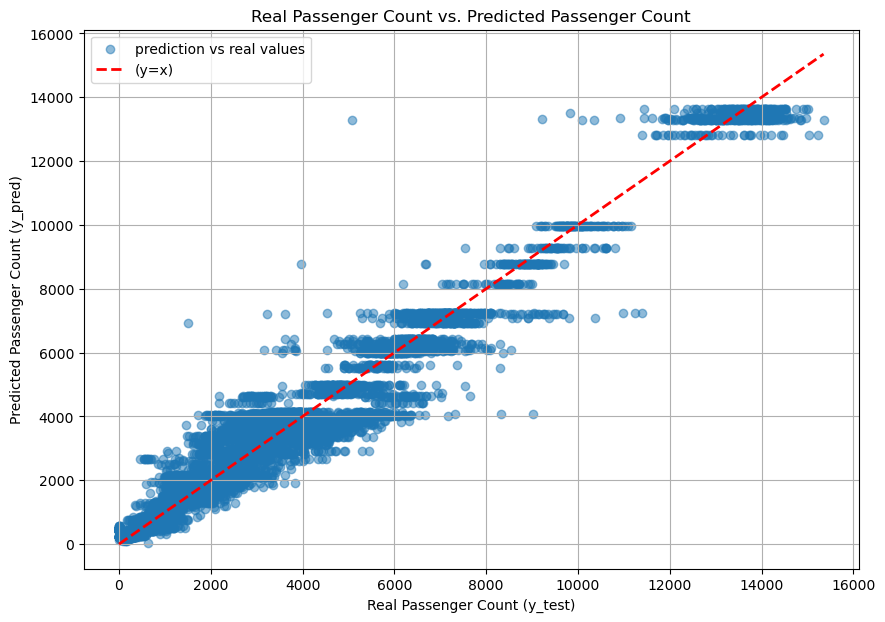

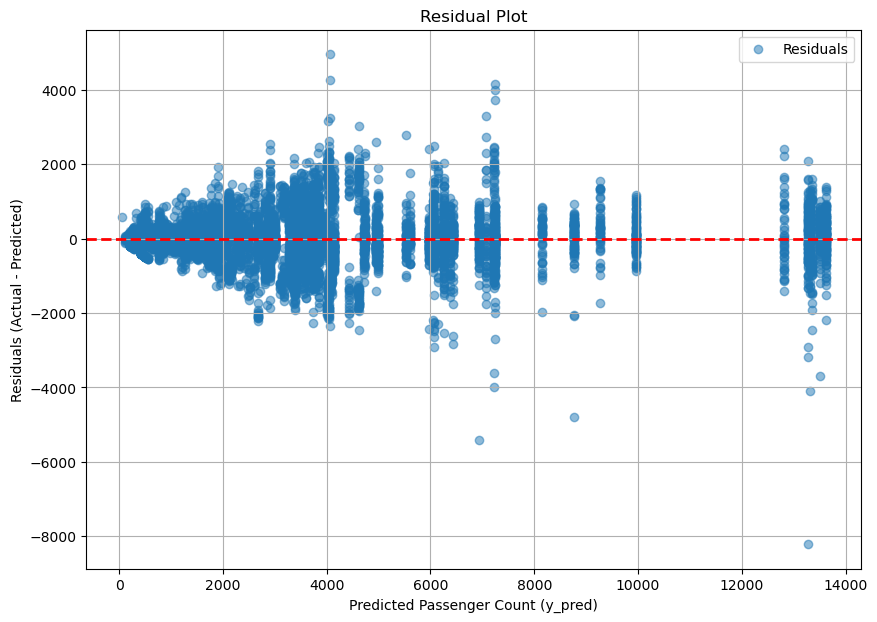

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# y_test와 y_pred가 이전 셀에서 이미 정의되었다고 가정합니다.
# (예: cell id '7279279a' 또는 'a0719358' 이후)

plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.5, label='prediction vs real values')
plt.xlabel("Real Passenger Count (y_test)")
plt.ylabel("Predicted Passenger Count (y_pred)")
plt.title("Real Passenger Count vs. Predicted Passenger Count")

# 완벽한 예측선을 위한 대각선 추가
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='(y=x)')

plt.legend()
plt.grid(True)
plt.show()

# 추가적으로 잔차도(Residual Plot)도 유용합니다.
# 잔차 = 실제 값 - 예측 값
residuals = y_test - y_pred

plt.figure(figsize=(10, 7))
plt.scatter(y_pred, residuals, alpha=0.5, label='Residuals')
plt.xlabel("Predicted Passenger Count (y_pred)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--', lw=2) # 기준선
plt.legend()
plt.grid(True)
plt.show()

In [96]:
new_X = pd.DataFrame([[8, 1, 0, 0.9, 0, 0]], columns=['시간', '승하차구분', '호선', '기온(°C)', '강수량(mm)', '주말'])
pred_y = model.predict(new_X)
print(f"예측된 승차인원: {10**pred_y[0]+1:.0f}")  # 로그 변환을 되돌림
print(f"예측된 승차인원: {pred_y[0]:.0f}") 

예측된 승차인원: 8890
예측된 승차인원: 4


## 안되는거

In [123]:
subdat = sub2023[sub2023['수송일자'] < '2023-01-30']

In [140]:
subdat = sub2023[sub2023['수송일자'] < '2023-01-30']


sub2023dat = pd.DataFrame({'고유역번호' : subdat['역번호'], 
                            '승하차구분' : subdat['승하차구분'],
                            '평균' : subdat.iloc[:,6:].mean(axis=1)})
sub2avg = sub2023dat.groupby(['고유역번호', '승하차구분'])['평균'].mean().reset_index()
city = subdat.groupby(['역번호', '승하차구분'])['08-09시간대'].mean()
city = city.reset_index()

In [142]:
def create_trainingset_with_norm(Tempdat, subdat, stn):
    # input : Tempdat - 일시, 기온(°C), 강수량(mm)
    #          subdat - 일자, 시간(가로축), 승하차구분, 호선, 승차인원
    # output : Df - 일자, 시간, 기온(°C), 강수량(mm), 승하차구분, 호선, 승차인원
    Temparr = Tempdat[['일시','기온(°C)','강수량(mm)']] 
    Temparr['일시'] = pd.to_datetime(Temparr['일시'])
    Temparr['강수량(mm)'] = Temparr['강수량(mm)'].fillna(0)
    # subdat은 6시이전 ~ 24시까지이므로 1,2,3,4시 데이터를 Tempdat에서 제외
    hours_to_exclude = [1, 2, 3, 4]
    Temparr = Temparr[~Temparr['일시'].dt.hour.isin(hours_to_exclude)]
    Temparr['시간'] = Temparr['일시'].dt.hour
    Temparr['일시'] = Temparr['일시'].dt.date
    # Temp의 1월 1일 00시 데이터 제거
    Temparr = Temparr.drop(Temparr.index[0])
    subdat_stn = subdat[(subdat['역명']==stn)] # stn에 해당하는 역 데이터만 추출출
    subdat_stn['수송일자'] = pd.to_datetime(subdat_stn['수송일자'])
    passenger = subdat_stn.iloc[:,6:].values.flatten() # 승차인원의 시간별 데이터를 세로로 펴기기
    if passenger.sum() == 0:
        print(f"Warning: No passenger data for station {stn}. Returning empty DataFrame.")
        return pd.DataFrame(columns=['일자', '시간', '기온(°C)', '강수량(mm)', '승하차구분', '호선', '승차인원', '주말', '연평균이용', '도심지'])
    hour = np.arange(0,len(passenger)) % 20 + 5 # 시간은 5시부터 시작하므로 0~19를 5~24로 변환
    hour[hour == 24] = 0 # 24시를 0시로 변환
    
    # subdat_stn에서 시간을 세로축에 넣어 데이터를 재구성, 5시~24시까지의 데이터가 추가되므로 20개씩 반복복
    subdat_stn_New = pd.DataFrame({
        '일자': subdat_stn['수송일자'].values.repeat(20),
        '시간': hour,
        '역번호' : subdat_stn['역번호'].values.repeat(20),
        '승하차구분' : subdat_stn['승하차구분'].values.repeat(20),
        '호선' : subdat_stn['호선'].values.repeat(20),
        '승차인원': passenger
    })
    # 24시의 일자를 다음날로 변경 (예: 2023-01-01 24시 -> 2023-01-02 00시)
    mask = subdat_stn_New['시간'] == 0
    subdat_stn_New.loc[mask, '일자'] = subdat_stn_New.loc[mask, '일자'] + pd.Timedelta(days=1)
    # subdat_stn_New의 일자를 date 타입으로 변환 (비교를 위해)
    subdat_stn_New['일자'] = subdat_stn_New['일자'].dt.date

    # 일자와 시간을 기준으로 left join
    subdat_stn_New_arr = subdat_stn_New.merge(
        Temparr,
        left_on=['일자', '시간'],
        right_on=['일시', '시간'],
        how='left'
    )
    subdat_stn_New_arr = subdat_stn_New_arr.drop(columns=['일시'])
    subdat_stn_New_arr['일자'] = pd.to_datetime(subdat_stn_New_arr['일자'])
    subdat_stn_New_arr = subdat_stn_New_arr.dropna()
    # 주말과 휴일 기입, 주말 = 1, 휴일 = 2, 주말인데 휴일인 날도 2로 처리
    weekend = subdat_stn_New_arr['일자'].dt.weekday >=5
    subdat_stn_New_arr['주말'] = 0
    subdat_stn_New_arr['주말'][weekend]=1
    vacation_2023 = np.array([dt.date(2023,1,1), dt.date(2023,1,21), dt.date(2023,1,22), dt.date(2023,1,23),
                     dt.date(2023,1,24), dt.date(2023,3,1), dt.date(2023,5,5),dt.date(2023,5,27),
                     dt.date(2023,5,29), dt.date(2023,6,6), dt.date(2023,8,15),
                     dt.date(2023,9,28), dt.date(2023,9,29), dt.date(2023,9,30),
                      dt.date(2023,10,2), dt.date(2023,10,3),dt.date(2023,10,9),
                      dt.date(2023,12,25)])
    vacation_2024 = np.array([dt.date(2024,1,1),dt.date(2024,2,9), dt.date(2024,2,10),
                            dt.date(2024,2,11),dt.date(2024,2,12),
                            dt.date(2024,3,1),dt.date(2024,4,10),dt.date(2024,5,5),
                            dt.date(2024,5,6),dt.date(2024,5,15),dt.date(2024,6,6),
                            dt.date(2024,8,15),dt.date(2024,9,16), dt.date(2024,9,17),
                            dt.date(2024,9,18),dt.date(2024,10,3),dt.date(2024,10,9),
                            dt.date(2024,12,25)])
    if subdat_stn_New_arr['일자'].dt.year.min() == 2023:
        subdat_stn_New_arr['주말'][subdat_stn_New_arr['일자'].dt.date.isin(vacation_2023)] = 2 #
    else:
        subdat_stn_New_arr['주말'][subdat_stn_New_arr['일자'].dt.date.isin(vacation_2024)] = 2

    # if '시간' == 8 & '승하차구분'==0 (승차) 승차인원 > ['시간'==8] & ['승하차구분'==1] -> '일자리' == 0 else : '일자리' == 1
    # add 연평균 이용인원
    subdat_stn_New_arr['연평균이용'] = 0
    subdat_stn_New_arr['도심지'] = 0
    stnnum = subdat_stn_New_arr['역번호'].unique()[0]
    subdat_stn_New_arr['연평균이용'][(subdat_stn_New_arr['승하차구분']=='승차')] = sub2avg['평균'][(sub2avg['고유역번호']==stnnum) & (sub2avg['승하차구분']=='승차')].values[0]
    subdat_stn_New_arr['연평균이용'][(subdat_stn_New_arr['승하차구분']=='하차')] = sub2avg['평균'][(sub2avg['고유역번호']==stnnum) & (sub2avg['승하차구분']=='하차')].values[0]

    citycond = city[(city['역번호'] == stnnum) & (city['승하차구분'] == '승차')]['08-09시간대'].values[0] - city[(city['역번호'] == stnnum) & (city['승하차구분'] == '하차')]['08-09시간대'].values[0] < 0
    if citycond:
        subdat_stn_New_arr['도심지'] = 1
    return subdat_stn_New_arr

In [143]:
df1 = create_trainingset_with_norm(Temp2023, sub2023, '당고개')

In [155]:
import warnings
warnings.filterwarnings('ignore')

subwaystn = sub2023['역명'].unique()
base_columns = ['일자', '시간', '승하차구분', '호선', '승차인원', '기온(°C)', '강수량(mm)', '주말', '연평균이용', '도심지']
all_stn = pd.DataFrame(columns=base_columns)
for stn in subwaystn:
    df = create_trainingset_with_norm(Temp2023, sub2023, stn)
    df2 = create_trainingset_with_norm(Temp2024, sub2024, stn)
    if not df.empty:
        print(stn, df['연평균이용'].values[0])
    all_stn = pd.concat([all_stn, df, df2], ignore_index=True)


서울역 2245.6724137931033
시청 1021.4689655172414
종각 1600.7241379310344
종로3가 1155.598275862069
종로5가 1029.0120689655173
동대문 508.1603448275862
신설동 577.9586206896552
제기동 782.5672413793104
청량리(서울시립대입구) 884.7672413793103
동묘앞 403.1534482758621
을지로입구 1896.9396551724137
을지로3가 982.5379310344827
을지로4가 550.3931034482758
동대문역사문화공원(DDP) 597.8620689655172
신당 607.9551724137931
상왕십리 603.4931034482759
왕십리(성동구청) 686.198275862069
한양대 318.13448275862066
뚝섬 933.4896551724138
성수 1637.7775862068966
건대입구 1636.6379310344828
구의(광진구청) 1023.4620689655173
강변(동서울터미널) 1430.6879310344827
잠실나루 596.7465517241379
잠실(송파구청) 3416.6637931034484
잠실새내 962.4724137931034
종합운동장 326.32586206896553
삼성(무역센터) 2227.4344827586206
선릉 2237.4672413793105
역삼 2083.537931034483
강남 3517.9965517241376
교대(법원.검찰청) 1341.0258620689656
서초 915.5034482758621
방배 661.5862068965517
사당 1710.2672413793102
낙성대(강감찬) 1181.3172413793102
서울대입구(관악구청) 1999.8155172413794
봉천 1027.7551724137932
신림 2502.1275862068965
신대방 1106.3706896551723
구로디지털단지 2462.441379310345
대림(구

In [158]:
all_stn = all_stn[all_stn['연평균이용'] != 0]

In [159]:
# ...existing code...
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 범주형 변수 인코딩
#df_ml = pd.concat([df1, df2], ignore_index=True)
#df_ml['승차인원'] = np.log10(df_ml['승차인원']+1)  # 승차인원 로그 변환
df_ml = all_stn.copy()
df_ml['승하차구분'] = df_ml['승하차구분'].astype('category').cat.codes
df_ml['호선'] = df_ml['호선'].astype('category').cat.codes

# 입력 변수와 출력 변수 지정
X = df_ml[['시간', '승하차구분', '주말', '연평균이용', '도심지']]
y = df_ml['승차인원']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestRegressor 모델 학습 및 예측
model = RandomForestRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# MSE 계산
mse = mean_squared_error(y_test.astype(float), y_pred)
print(f"테스트 MSE: {mse:.2f}")

테스트 MSE: 105018.54


In [160]:
np.sqrt(mse)

324.0656346203696

In [15]:
# 안 쓰는 코드
"""
Temp2023 = pd.read_csv('Temp2023.csv', encoding='cp949')
Temp2023 = Temp2023[['일시','기온(°C)','강수량(mm)']]
# nan을 0으로 채우기
Temp2023['강수량(mm)'] = Temp2023['강수량(mm)'].fillna(0)
# 일시에서 시간을 따로 추출하여 행으로 추가함
# 일시는 날짜 성분만 남김
Temp2023['일시'] = pd.to_datetime(Temp2023['일시'])
hours_to_exclude = [1, 2, 3, 4]
Temp2023 = Temp2023[~Temp2023['일시'].dt.hour.isin(hours_to_exclude)]
Temp2023['시간'] = Temp2023['일시'].dt.hour
Temp2023['일시'] = Temp2023['일시'].dt.date
Temp2023 = Temp2023.drop(Temp2023.index[0])

# 시간이 0인 행들의 일시에서 하루 빼기
# 먼저 일시를 다시 datetime으로 변환 (현재 date 타입이므로)
#Temp2023['일시'] = pd.to_datetime(Temp2023['일시'])

# 시간이 0인 행들의 일시에서 1일 빼기
#mask = Temp2023['시간'] == 0
#Temp2023.loc[mask, '일시'] = Temp2023.loc[mask, '일시'] - pd.Timedelta(days=1)

# 필요하다면 다시 date 타입으로 변환
#Temp2023['일시'] = Temp2023['일시'].dt.date

# 인덱스 재설정 (선택사항)
#Temp2023 = Temp2023.reset_index(drop=True)

# 시청 먼저 해보기기
sub2023_cityhall = sub2023[(sub2023['역명']=='시청')]
sub2023_cityhall['수송일자'] = pd.to_datetime(sub2023_cityhall['수송일자'])
# 새로운 데이터프레임 생성
# 시간을 새로운 column으으로 추가할 것임
passenger = sub2023_cityhall.iloc[:,6:].values.flatten()
hour = np.arange(0,len(passenger)) % 20 + 5
hour[hour == 24] = 0
sub2023df = pd.DataFrame({
    '일자': sub2023_cityhall['수송일자'].values.repeat(20),
    '시간': hour,
    '승하차구분' : sub2023_cityhall['승하차구분'].values.repeat(20),
    '호선' : sub2023_cityhall['호선'].values.repeat(20),
    '승차인원': passenger
})
mask = sub2023df['시간'] == 0
sub2023df.loc[mask, '일자'] = sub2023df.loc[mask, '일자'] + pd.Timedelta(days=1)
# sub2023df의 일자를 date 타입으로 변환 (비교를 위해)
sub2023df['일자_date'] = sub2023df['일자'].dt.date
# 일자와 시간을 기준으로 left join
sub2023dfarr = sub2023df.merge(
    Temp2023,
    left_on=['일자_date', '시간'],
    right_on=['일시', '시간'],
    how='left'
)
sub2023dfarr = sub2023dfarr.drop(columns=['일자_date', '일시'])
sub2023dfarr['일자'] = pd.to_datetime(sub2023dfarr['일자'])
"""

"\nTemp2023 = pd.read_csv('Temp2023.csv', encoding='cp949')\nTemp2023 = Temp2023[['일시','기온(°C)','강수량(mm)']]\n# nan을 0으로 채우기\nTemp2023['강수량(mm)'] = Temp2023['강수량(mm)'].fillna(0)\n# 일시에서 시간을 따로 추출하여 행으로 추가함\n# 일시는 날짜 성분만 남김\nTemp2023['일시'] = pd.to_datetime(Temp2023['일시'])\nhours_to_exclude = [1, 2, 3, 4]\nTemp2023 = Temp2023[~Temp2023['일시'].dt.hour.isin(hours_to_exclude)]\nTemp2023['시간'] = Temp2023['일시'].dt.hour\nTemp2023['일시'] = Temp2023['일시'].dt.date\nTemp2023 = Temp2023.drop(Temp2023.index[0])\n\n# 시간이 0인 행들의 일시에서 하루 빼기\n# 먼저 일시를 다시 datetime으로 변환 (현재 date 타입이므로)\n#Temp2023['일시'] = pd.to_datetime(Temp2023['일시'])\n\n# 시간이 0인 행들의 일시에서 1일 빼기\n#mask = Temp2023['시간'] == 0\n#Temp2023.loc[mask, '일시'] = Temp2023.loc[mask, '일시'] - pd.Timedelta(days=1)\n\n# 필요하다면 다시 date 타입으로 변환\n#Temp2023['일시'] = Temp2023['일시'].dt.date\n\n# 인덱스 재설정 (선택사항)\n#Temp2023 = Temp2023.reset_index(drop=True)\n\n# 시청 먼저 해보기기\nsub2023_cityhall = sub2023[(sub2023['역명']=='시청')]\nsub2023_cityhall['수송일자'] = pd.to_datetime(sub

In [22]:
df_ml['호선']==0

0        True
1        True
2        True
3        True
4        True
         ... 
29231    True
29232    True
29233    True
29234    True
29235    True
Name: 호선, Length: 29236, dtype: bool

# 데이터 분석

In [26]:
test1 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==2) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']==0)]['승차인원']
from scipy.stats import anderson
result = anderson(test1)
result.statistic, result.critical_values, result.significance_level

(0.6351547341855834,
 array([0.523, 0.596, 0.715, 0.834, 0.992]),
 array([15. , 10. ,  5. ,  2.5,  1. ]))

In [24]:
test2 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==1) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']==0)]['승차인원']
test3 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==0) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']==0)]['승차인원']
test4 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==2) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']>0)]['승차인원']
test5 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==1) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']>0)]['승차인원']
test6 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==0) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']>0)]['승차인원']

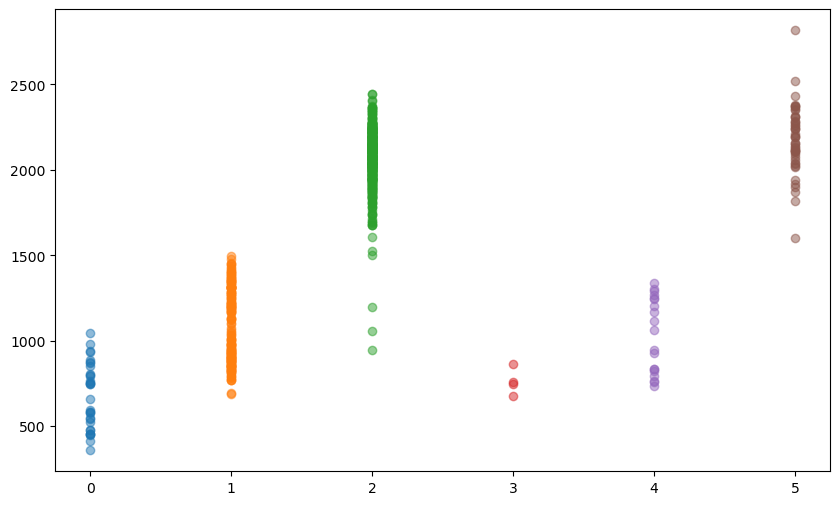

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(test1.values*0, test1.values, alpha=0.5)
plt.scatter(np.ones_like(test2), test2.values, alpha=0.5)
plt.scatter(np.ones_like(test3)*2, test3.values, alpha=0.5)
plt.scatter(np.ones_like(test4)*3, test4.values, alpha=0.5)
plt.scatter(np.ones_like(test5)*4, test5.values, alpha=0.5)
plt.scatter(np.ones_like(test6)*5, test6.values, alpha=0.5)

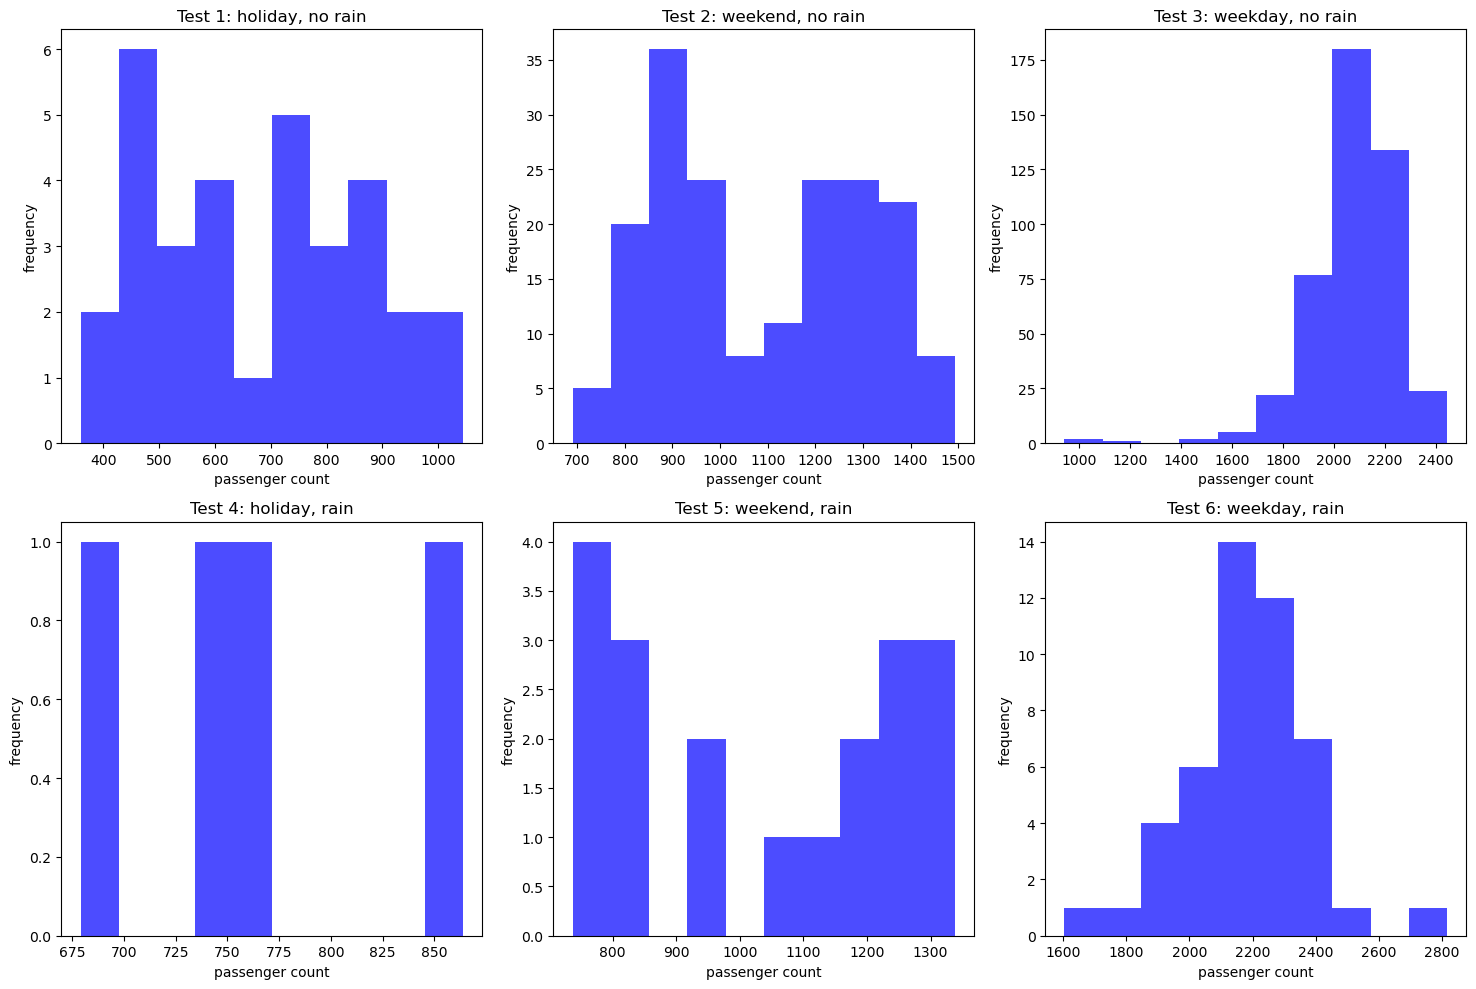

In [36]:


import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten() # 2x3 배열을 1차원 배열로 만듭니다.

datasets = [test1, test2, test3, test4, test5, test6]
titles = ['Test 1: holiday, no rain', 'Test 2: weekend, no rain', 'Test 3: weekday, no rain', 
          'Test 4: holiday, rain', 'Test 5: weekend, rain', 'Test 6: weekday, rain']

for i, data in enumerate(datasets):
    axes[i].hist(data, bins=10, alpha=0.7, color='blue')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('passenger count')
    axes[i].set_ylabel('frequency')

plt.tight_layout() # 서브플롯 간 간격 자동 조정
plt.show()
